In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import os 


In [5]:
def rotate_image(arr, angle):
   height, width = arr.shape[:2]
   # get the image centers
   image_center = (width/2, height/2)

   rotation_arr = cv2.getRotationMatrix2D(image_center, angle, 1)

   abs_cos = abs(rotation_arr[0,0])
   abs_sin = abs(rotation_arr[0,1])

   bound_w = int(height * abs_sin + width * abs_cos)
   bound_h = int(height * abs_cos + width * abs_sin)

   rotation_arr[0, 2] += bound_w/2 - image_center[0]
   rotation_arr[1, 2] += bound_h/2 - image_center[1]

   rotated_mat = cv2.warpAffine(arr, rotation_arr, (bound_w, bound_h))
 
   return rotated_mat

def d1xO4(u, h):
    m, n = u.shape
    u1 = np.concatenate((u[:, n-2:n], u, u[:, 0:2]), axis=1)
    dxdu = (1 / (12 * h)) * (u1[:, 0:n] - 8 * u1[:, 1:n+1] + 8 * u1[:, 3:n+3] - u1[:, 4:n+4])
    return dxdu

def d1yO4(u, h):
    m, n = u.shape
    u1 = np.concatenate((u[m-2:m, :], u, u[0:2, :]), axis=0)
    dxdu = (1 / (12 * h)) * (u1[0:m, :] - 8 * u1[1:m+1, ] + 8 * u1[3:m+3, :] - u1[4:m+4, :])
    return dxdu

def d2xO4(u, h):
    m, n = u.shape
    u1 = np.concatenate((u[:, n-2:n], u, u[:, 0:2]), axis=1)
    d2xdu = (1 / (12 * h**2)) * (-u1[:, 0:n] + 16 * u1[:, 1:n+1] - 30 * u1[:, 2:n+2] + 16 * u1[:, 3:n+3] - u1[:, 4:n+4])
    return d2xdu

def d2yO4(u, h):
    m, n = u.shape
    u1 = np.concatenate((u[m-2:m, :], u, u[0:2, :]), axis=0)
    d2ydu = (1 / (12 * h**2)) * (-u1[0:m, :] + 16 * u1[1:m+1, :] - 30 * u1[2:m+2, :] + 16 * u1[3:m+3, :] - u1[4:m+4, :])
    return d2ydu

def LaplO4(u, h):
    return d2xO4(u,h) + d2yO4(u,h)
def diff_ccw(a, b):
    c = b - a

    # There are 3 cases
    # First, C is greater than pi/2 then we have to invert the angle of b to get the smallest difference
    c[c >= np.pi / 2] = c[c >= np.pi / 2] - np.pi

    # Second case is when C is less than -pi/2. We have to invert the angle of a
    c[c <= -np.pi / 2] = c[c <= -np.pi / 2] + np.pi

    delta = c
    return delta
def detect_defect(theta):
    # Consider the following matrix where each entry represents the angle of the particle.
    # theta = [ A | B ]
    #         [ C | D ]

    # Calculate angles around a point D by using circshift
    # theta_left = [ B | A ]
    #              [ D | C ]
    #              --------> shifted right so that element (i, j) of theta_left
    #                        represents a grid to the left of the original theta
    theta = np.mod(theta, np.pi)
    theta_left = np.roll(theta, shift=(0, 1), axis=(0, 1))
    theta_up = np.roll(theta, shift=(1, 0), axis=(0, 1))
    theta_left_up = np.roll(theta, shift=(1, 1), axis=(0, 1))

    # Calculate the difference between theta of a loop in space
    up_diff = diff_ccw(theta, theta_up)
    up_left_diff = diff_ccw(theta_up, theta_left_up)
    left_diff = diff_ccw(theta_left_up, theta_left)
    diff = diff_ccw(theta_left, theta)

    # Check if angle is pi/2 or -pi/2 or 0.
    tol = 0.3
    strength = up_diff + up_left_diff + left_diff + diff
    loc12 = np.abs(strength + np.pi) / np.pi < tol
    loc_12 = np.abs(strength - np.pi) / np.pi < tol

    return loc12, loc_12
def CreatePeriodicMatrix(matrix,delta_r):
    lenth = matrix.shape[0]
    width = matrix.shape[1]
    matrix_bigger = np.zeros((lenth+2*delta_r,width+2*delta_r))
   
    matrix_bigger[delta_r:lenth+delta_r , delta_r:width+delta_r] = matrix



    matrix_bigger[0:delta_r,0:delta_r] = matrix[lenth-delta_r:lenth,width-delta_r:]
    matrix_bigger[0:delta_r,delta_r:lenth+delta_r] = matrix[lenth-delta_r:lenth,:]
    matrix_bigger[0:delta_r,lenth+delta_r:] = matrix[lenth-delta_r:lenth,0:delta_r]


    matrix_bigger[lenth+delta_r:,0:delta_r] = matrix[0 :delta_r,width-delta_r:]
    matrix_bigger[lenth+delta_r:,delta_r:lenth+delta_r] = matrix[0:delta_r,:]
    matrix_bigger[lenth+delta_r:,lenth+delta_r:] = matrix[0:delta_r,0:delta_r]


    matrix_bigger[delta_r:lenth+delta_r,0:delta_r] = matrix[:,width-delta_r:]
    matrix_bigger[delta_r:lenth+delta_r,width+delta_r:] = matrix[:,0:delta_r]

    return matrix_bigger

def defect_orie(xD, k, Qxx, Qxy, Loop,h):
    dn = Loop
    m, n = Qxx.shape

    dxQxx = d1xO4(Qxx, h)
    dxQxy = d1xO4(Qxy, h)
    dyQxx = d1yO4(Qxx, h)
    dyQxy = d1yO4(Qxy, h)

    signk = np.sign(k)

    top = signk * dxQxy - dyQxx
    bottom = dxQxx + signk * dyQxy

    top1 = np.block([[top[m - dn:m, n - dn:n], top[m - dn:m, :], top[m - dn:m, 0:dn]],
                        [top[:, n - dn:n], top, top[:, 0:dn]],
                        [top[0:dn, n - dn:n], top[0:dn, :], top[0:dn, 0:dn]]])

    bottom1 = np.block([[bottom[m - dn:m, n - dn:n], bottom[m - dn:m, :],
                            bottom[m - dn:m, 0:dn]],
                        [bottom[:, n - dn:n], bottom, bottom[:, 0:dn]],
                        [bottom[0:dn, n - dn:n], bottom[0:dn, :], bottom[0:dn, 0:dn]]])

    topa = np.zeros((m, n))
    bottoma = np.zeros((m, n))

    for j in range(-Loop, Loop):
        for i in range(-Loop, Loop):
            topa += top1[dn + i:dn + m + i, dn + j:dn + n + j]
            bottoma += bottom1[dn + i:dn + m + i, dn + j:dn + n + j]

    pD = k / (1 - k) * xD * np.arctan2(topa, bottoma)

    return pD

def ConvertToPassive(angle):
    return (angle%(np.pi)+np.pi)%(np.pi)


In [19]:

AA = -187
DC = 10
V0=10
vmax1 = 160

savenames = ["test57",]
steph = 1
size = 128 * steph
for savename in savenames:

    # datadir = "/home/lyuan/share/LLC/T_phase/data/heat_Dc10/4NL128/"+savename+"/"
    # savedir = "/home/lyuan/share/LLC/T_phase/photo_video/heat_Dc10/4NL128/"+savename+"/"
    datadir = "../data/"+savename+"/"
    savedir = "../photo_video/"+savename+"/"
    if not os.path.exists(savedir):
        os.makedirs(savedir,exist_ok=True)
    
    imes = 30
    cbsize = 16
    titlesize = 20
    # v_mean = np.zeros(times+1)

    range_theta = 10
    
    defect_theta_bacteria = np.zeros((2*range_theta,2*range_theta))# 细菌缺陷周围的细菌指向
    defect_theta_nematics = np.zeros((2*range_theta,2*range_theta))# 液晶缺陷周围的液晶指向
    
    
    defect_theta_bn = np.zeros((2*range_theta,2*range_theta))# 细菌缺陷周围的液晶指向
    defect_theta_nb = np.zeros((2*range_theta,2*range_theta))# 液晶缺陷周围的细菌指向
    
    defect_S2_bacteria = np.zeros((2*range_theta,2*range_theta))
    defect_S2_nematics = np.zeros((2*range_theta,2*range_theta))
    
    defect_P2_bacteria = np.zeros((2*range_theta,2*range_theta))
    defect_P2_nematics = np.zeros((2*range_theta,2*range_theta))
    
    defect_vx_bacteria = np.zeros((2*range_theta,2*range_theta))
    defect_vx_nematics = np.zeros((2*range_theta,2*range_theta))
    
    defect_vy_bacteria = np.zeros((2*range_theta,2*range_theta))
    defect_vy_nematics = np.zeros((2*range_theta,2*range_theta))
    
    
    vx_defectN = np.zeros((2*range_theta,2*range_theta))
    vy_defectN = np.zeros((2*range_theta,2*range_theta))
    vx_defectP = np.zeros((2*range_theta,2*range_theta))
    vy_defectP = np.zeros((2*range_theta,2*range_theta))
    v_defectN = np.zeros((2*range_theta,2*range_theta))
    v_defectP = np.zeros((2*range_theta,2*range_theta))
    S_defectN = np.zeros((2*range_theta,2*range_theta))
    S_defectP = np.zeros((2*range_theta,2*range_theta))
    omegaP = np.zeros((2*range_theta,2*range_theta))
    defect_Qxx_nematics= np.zeros((2*range_theta,2*range_theta))
    defect_Qxy_nematics= np.zeros((2*range_theta,2*range_theta))    
    defect_Pxx_nematics= np.zeros((2*range_theta,2*range_theta))
    defect_Pxy_nematics= np.zeros((2*range_theta,2*range_theta))
    
    omegaN = np.zeros((2*range_theta,2*range_theta))
    num_nematics = 1
    num_bacteria = 1
    ii=0
    bin_c = np.zeros(vmax1)
    bin_vx = np.zeros(vmax1)
    bin_vy = np.zeros(vmax1)
    bin_vxhc = np.zeros(vmax1)
    bin_vyhc = np.zeros(vmax1)
    bin_vxlc = np.zeros(vmax1)
    bin_vylc = np.zeros(vmax1)
    

In [20]:

time = 39

omega_df = pd.read_csv(datadir + "incompFlow.omega_%d.dat"%time,header=None)
vx_df = pd.read_csv(datadir + "incompFlow.vx_%d.dat"%time,header=None)
vy_df = pd.read_csv(datadir + "incompFlow.vy_%d.dat"%time,header=None)
Qxx_df = pd.read_csv(datadir + "abParticle.Qxx_%d.dat"%time,header = None)
Qxy_df = pd.read_csv(datadir + "abParticle.Qxy_%d.dat"%time,header = None)
Pxx_df = pd.read_csv(datadir + "abParticle.Pxx_%d.dat"%time,header = None)
Pxy_df = pd.read_csv(datadir + "abParticle.Pxy_%d.dat"%time,header = None)
anchx_df = pd.read_csv(datadir + "anchx_%d.dat"%time,header = None)
anchy_df = pd.read_csv(datadir + "anchy_%d.dat"%time,header = None)
C_df = pd.read_csv(datadir + "abParticle.Concentration_%d.dat"%time,header=None)
kk = pd.read_csv("./"+"conf_%d"%time+".dat",sep=" ",header=None)

# kk = pd.read_csv(datadir+"conf_%d"%time+".dat",sep=" ",header=None)
    # print(kk.shape)
pts = np.array(kk)


Pxx = np.array(Pxx_df).reshape(size,-1,order = "F").T
Pxy = np.array(Pxy_df).reshape(size,-1,order = "F").T
# phix = np.array(phix_df).reshape(size,-1)
# phiy = np.array(phiy_df).reshape(size,-1)
anchx = np.array(anchx_df).reshape(size,-1,order = "F").T
anchy = np.array(anchy_df).reshape(size,-1,order = "F").T
omega = np.array(omega_df).reshape(size,size,order = "F").T
vx = np.array(vx_df).reshape(size,size,order = "F").T
vy = np.array(vy_df).reshape(size,size,order = "F").T
Qxx = np.array(Qxx_df).reshape(size,size,order = "F").T
Qxy = np.array(Qxy_df).reshape(size,size,order = "F").T
C = np.array(C_df).reshape(size,size,order = "F").T
print(Qxx[0:2,0:2])
S2 = 4*Qxx**2+4*Qxy**2
A2 = 4*anchx**2+4*anchy**2
# print(np.mean(S2))
# print(np.max(S2))


omegav = d1xO4(vy,steph) - d1yO4(vx,steph)
eta = 0.5
h = 20
zta = 12*eta/h/2
left = zta * omega - eta* LaplO4(omega,steph)
P2 = 4*Pxx**2 + 4*Pxy**2 
# print(np.mean(P2))
# print(np.max(P2))

theta = 0.5 * np.arctan2(Qxy,Qxx)
cut_size = 4
cut_size1 = 1
print(np.max(theta))
print(np.min(theta))
# theta = np.pi-theta
n1 = np.cos(theta)
n2 = np.sin(theta)
# print(theta)
n1cut = n1[::cut_size,::cut_size]
n2cut = n2[::cut_size,::cut_size]
nn_1 = n1*n1

nn_2 = n1*n2
theta1 = 0.5 * np.arctan2(Pxy,Pxx)
p11 = np.cos(theta1)
p22 = np.sin(theta1)
p11cut = p11[::cut_size,::cut_size]
p22cut = p22[::cut_size,::cut_size]

# v_mean[time-1] = np.mean(np.sqrt(vx**2+vy**2))
nabla_v = d1xO4(vx,1) + d1yO4(vy,1)
theta2 = 0.5 * np.arctan2(anchy,anchx)
a1 = np.cos(theta2)
a2 = np.sin(theta2)
a1cut = a1[::cut_size,::cut_size]
a2cut = a2[::cut_size,::cut_size]


ValueError: cannot reshape array of size 262144 into shape (128,128)

(370.0, 380.0)

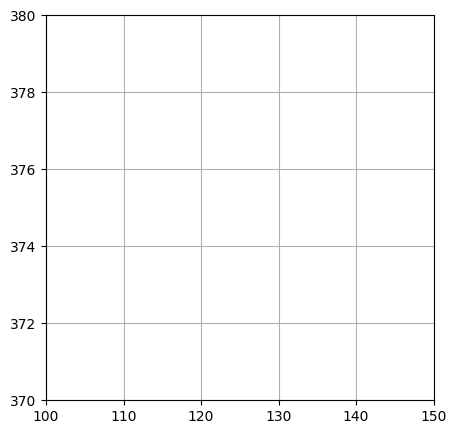

In [21]:
fig = plt.figure(figsize = [5,5])

ax = fig.add_subplot(1,1,1)
# im = ax.imshow(omega,origin='lower',vmax = 6,vmin = -6, interpolation='gaussian', animated=True, cmap='jet')
# print(pts.shape)
ax.quiver(pts[:,0],pts[:,1],1*pts[:,2],1*pts[:,3],width=0.01, headwidth=4*1)
plt.grid()


ax.set_xlim(100,150)
ax.set_ylim(370,380)

(0.0, 500.0)

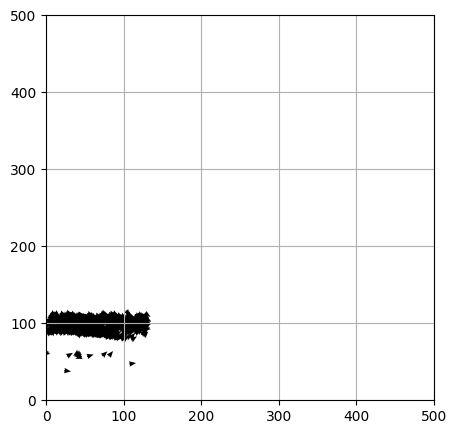

In [22]:
fig = plt.figure(figsize = [5,5])

ax = fig.add_subplot(1,1,1)
# im = ax.imshow(omega,origin='lower',vmax = 6,vmin = -6, interpolation='gaussian', animated=True, cmap='jet')
# print(pts.shape)
ax.quiver(pts[:,0],pts[:,1],1*pts[:,2],1*pts[:,3],width=0.01, headwidth=4*1)
plt.grid()


ax.set_xlim(0,500)
ax.set_ylim(0,500)

In [23]:
size =128

ValueError: operands could not be broadcast together with shapes (512,512) (2048,128) 

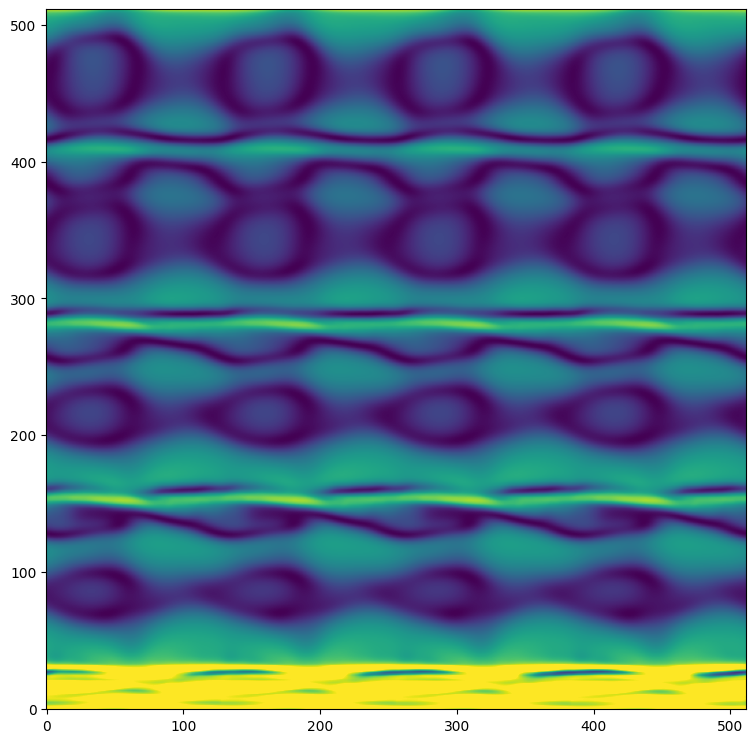

In [24]:
fig = plt.figure(figsize = [20,20])

ax = fig.add_subplot(2,2,1)
im = ax.imshow(S2,vmax =0.9,vmin= 0,norm=None,origin="lower")
X,Y = np.meshgrid(np.arange(size),np.arange(size))
xDP, xDM = detect_defect(theta)
pDP, pDM = detect_defect(theta1)
theta_xDP = defect_orie(xDP,0.5,Qxx,Qxy,2,steph)
theta_pDP = defect_orie(pDP,0.5,Pxx,Pxy,2,steph)
pyDP1, pxDP1 = np.where(pDP > 0.5)
pyDM1, pxDM1 = np.where(pDM > 0.5)
yDP1, xDP1 = np.where(xDP > 0.5)
yDM1, xDM1 = np.where(xDM > 0.5)
theta_bigger = CreatePeriodicMatrix(theta,range_theta)
theta1_bigger = CreatePeriodicMatrix(theta1,range_theta)
vx_bigger = CreatePeriodicMatrix(vx,range_theta)
vy_bigger = CreatePeriodicMatrix(vy,range_theta)
S2_bigger = CreatePeriodicMatrix(S2,range_theta)
P2_bigger = CreatePeriodicMatrix(P2,range_theta)
Qxx_bigger = CreatePeriodicMatrix(Qxx,range_theta)
Qxy_bigger = CreatePeriodicMatrix(Qxy,range_theta)
Pxx_bigger = CreatePeriodicMatrix(Pxx,range_theta)
Pxy_bigger = CreatePeriodicMatrix(Pxy,range_theta)


if num_bacteria !=0:
    defect_theta_bacteria1 = defect_theta_bacteria
    defect_theta_bn1 = defect_theta_bn/num_bacteria
    
    vx_defectP1 =vx_defectP/num_bacteria
    vy_defectP1 = vy_defectP/num_bacteria
    omegaP = d1xO4(vy_defectP1,steph) - d1yO4(vx_defectP1,steph)

if num_nematics != 0:
    defect_Qxx_nematics1 = defect_Qxx_nematics/num_nematics
    defect_Qxy_nematics1 = defect_Qxy_nematics/num_nematics
    defect_Pxx_nematics1 = defect_Pxx_nematics/num_nematics
    defect_Pxy_nematics1 = defect_Pxy_nematics/num_nematics
    defect_theta_nematics1 = 0.5*np.arctan2(defect_Qxy_nematics1,defect_Qxx_nematics1)
    defect_theta_nb1 = 0.5*np.arctan2(defect_Pxy_nematics1,defect_Pxx_nematics1)
    
    
    vx_defectN1 = vx_defectN/num_nematics
    # print(np.mean(vx_defectN1))
    vy_defectN1 = vy_defectN/num_nematics
    omegaN = d1xO4(vy_defectN1,steph) - d1yO4(vx_defectN1,steph)
    # print(np.mean(vy_defectN1))

ax.quiver(X[::cut_size,::cut_size],Y[::cut_size,::cut_size],n1cut,n2cut,color = "red" ,angles='xy', scale_units='xy', scale=1/6, headwidth=0, headlength=0 ,headaxislength=0, pivot='middle')
# ax.quiver(X[::cut_size,::cut_size],Y[::cut_size,::cut_size],vx[::cut_size,::cut_size],vy[::cut_size,::cut_size])
ax.quiver(X[::cut_size,::cut_size],Y[::cut_size,::cut_size],p11cut,p22cut,color = "#66CCFF",angles='xy', scale_units='xy', scale=1/4, headwidth=0, headlength=0 ,headaxislength=0, pivot='middle')
ax.scatter(pxDP1, pyDP1, c='black', marker='o',label='bacteria_DP1')
ax.quiver(pxDP1, pyDP1, np.cos(theta_pDP[pDP > 0.5]), np.sin(theta_pDP[pDP > 0.5]), color='black')

ax.scatter(xDP1, yDP1, c='red', marker='o',label='nematics_DP1')
ax.quiver(xDP1, yDP1, np.cos(theta_xDP[xDP > 0.5]), np.sin(theta_xDP[xDP > 0.5]), color='red')
# ax.scatter(xDP1, yDP1, c='red', marker='o',label='LC_DP1')
ax.legend(loc =1 )
# ax.scatter(pxDM1, pyDM1, c='m', marker='o', label='DM1')
# ax.quiver(X[::cut_size,::cut_size],Y[::cut_size,::cut_size],p11cut,p22cut)
# ax.quiver(X[::cut_size,::cut_size],Y[::cut_size,::cut_size],p111cut,p222cut,color = "green")
cb = plt.colorbar(im , ax=ax)
cb.ax.tick_params(labelsize=cbsize)
ax.set_title("Nematic,S2_max = %f,S2_mean = %f"%(np.max(S2),np.mean(S2)),size=titlesize)
ax.axis("off")



ax = fig.add_subplot(2,2,2)
# X,Y = np.meshgrid(np.arange(size),np.arange(size))
# im = ax.imshow(omega,vmax = 5,vmin = -5 ,origin='lower', interpolation='gaussian', animated=True, cmap='jet')
im = ax.imshow(omega,origin='lower',vmax = 6,vmin = -6, interpolation='gaussian', animated=True, cmap='jet')
ax.quiver(X[::cut_size,::cut_size],Y[::cut_size,::cut_size],vx[::cut_size,::cut_size],vy[::cut_size,::cut_size])
# ax.set_xlabel(None)

# ax.set_ylabel(None)
# ax.scatter(xDP1, yDP1, c='black', marker='o', label='DP1')
# ax.scatter(xDM1, yDM1, c='m', marker='o', label='DM1')
ax.scatter(pxDP1, pyDP1, c='black', marker='o',label='bacteria_DP1')
ax.quiver(pxDP1, pyDP1, np.cos(theta_pDP[pDP > 0.5]), np.sin(theta_pDP[pDP > 0.5]), color='black')

ax.scatter(xDP1, yDP1, c='red', marker='o',label='nematics_DP1')
ax.quiver(xDP1, yDP1, np.cos(theta_xDP[xDP > 0.5]), np.sin(theta_xDP[xDP > 0.5]), color='red')
# ax.scatter(xDP1, yDP1, c='red', marker='o',label='LC_DP1')
ax.legend(loc=1)
cb = plt.colorbar(im,ax = ax)
cb.ax.tick_params(labelsize=cbsize)
ax.set_title("Velocity",size= titlesize)
ax.axis("off")


# ax = fig.add_subplot(2,3,3)
# im = ax.imshow(defect_c_nematics,norm = None , origin='lower')
# ax.set_title("c_nematics")
# ax.axis("off")
# ax = fig.add_subplot(2,3,4)
# im = ax.imshow(defect_c_bacteria,norm = None, origin='lower')
# ax.set_title("c_bacteria")
# ax.axis("off")



ax = fig.add_subplot(2,2,3)
im = ax.imshow(C,norm = None,origin='lower')
# im = ax.imshow(cp+cm,vmax =0.6,vmin = 0,norm = None,origin='lower')
# ax.scatter(xDP1, yDP1, c='black', marker='o', label='DP1')
# ax.scatter(xDM1, yDM1, c='m', marker='o', label='DM1')
# ax.streamplot(X,Y,vx,vy)
cb = plt.colorbar(im,ax=ax)

ax.scatter(pxDP1, pyDP1, c='black', marker='o',label='bacteria_DP1')
ax.quiver(pxDP1, pyDP1, np.cos(theta_pDP[pDP > 0.5]), np.sin(theta_pDP[pDP > 0.5]), color='black')

ax.scatter(xDP1, yDP1, c='red', marker='o',label='nematics_DP1')
ax.quiver(xDP1, yDP1, np.cos(theta_xDP[xDP > 0.5]), np.sin(theta_xDP[xDP > 0.5]), color='red')
# ax.scatter(xDP1, yDP1, c='red', marker='o',label='LC_DP1')
ax.legend(loc = 1)
ax = fig.add_subplot(2,2,4)
# print(pts.shape)
ax.quiver(pts[:,0],pts[:,1],100*pts[:,2],100*pts[:,3],0.01)

ax.set_xlim(0,size)
ax.set_ylim(0,size)


# cb = plt.colorbar(im,ax=ax,)
# cb.ax.tick_params(labelsize=cbsize)
# ax.set_title("Concentration,P2_max = %f,P2_mean = %f"%(np.max(P2),np.mean(P2)),size = titlesize)
# ax.axis("off")





In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

# 空间单位 ：L（um） =  sqrt(K0/a) = sqrt(25 * 10-12 m2 ) = 5
# 时间单位 ：T (sec) = 1/Gamma0/a = 2.5
# 应力单位 ：sigma （N /m2 = kg/m/sec2） =  0.4
# 力单位 ：K_0 (pN) = 10



K0 = 10 #10-12N
Er0 = 3.75 
Gamma0 = 1 #m sec /kg   
eta0 = 0.5 # kg/m/sec  = sigma*T = 1

xian0 = 0.5 #1/sec = 1/2.5
h0 = 20 # um

a0 = 0.4#N/m2
b0 = 0.8#N/m2

l0 = 5 #um
V0 = 15 #um/sec = 2
tau = 200 #sec
Dc0 = 200 # um2/sec = 10
AA0 = 187# 10-12 N um = 50




In [ ]:
# 空间单位 ：L（um） =  sqrt(K0/a) = sqrt(25 * 10-12 m2 ) = 5
# 时间单位 ：T (sec) = 1/Gamma0/a = 2.5
# 应力单位 ：sigma （N /m2） =  0.4
K = 1
a = 1
Gamma = 1
b = 2
h = 4
eta = 0.5
xian = 1.25
l = 1
V0 = 7.5
tau = 80 # C+和 C-转化的弛豫时间
Dc = 20
AA = 3.74

concentration = 

